#### **Section I data loading**

* We ultize the EEG data in sleep process as the target data

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from utils import load_eeg_segment,plot_spectrum,plot_fixed_window_vary_length,add_interference_to_eeg, design_and_apply_fir_bandstop


In [2]:
edf_path = r"E:\UsefulFiles\Data\EEGData\SleppStage\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4001E0-PSG.edf"

start_time_sec = 0
duration_sec = 30
channel_name = 'EEG Fpz-Cz'
verbose = False

eeg, fs = load_eeg_segment(
    edf_path,
    start_time_sec=start_time_sec,
    duration_sec=duration_sec,
    channel_name=channel_name,
    verbose=verbose
)
eeg.shape,fs

c:\Users\yoru\Desktop\DSP_Project\utils.py:38: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=verbose)
c:\Users\yoru\Desktop\DSP_Project\utils.py:38: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=verbose)
c:\Users\yoru\Desktop\DSP_Project\utils.py:38: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=verbose)


((3000,), 100.0)

#### **Section II Specturm Anaysis**

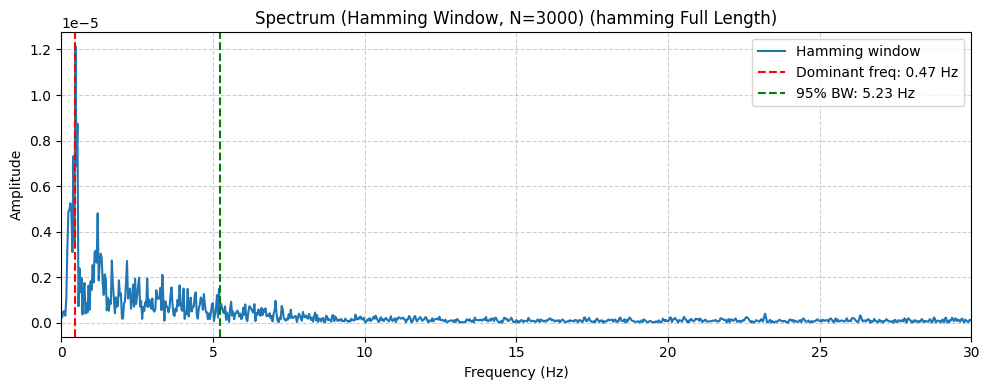

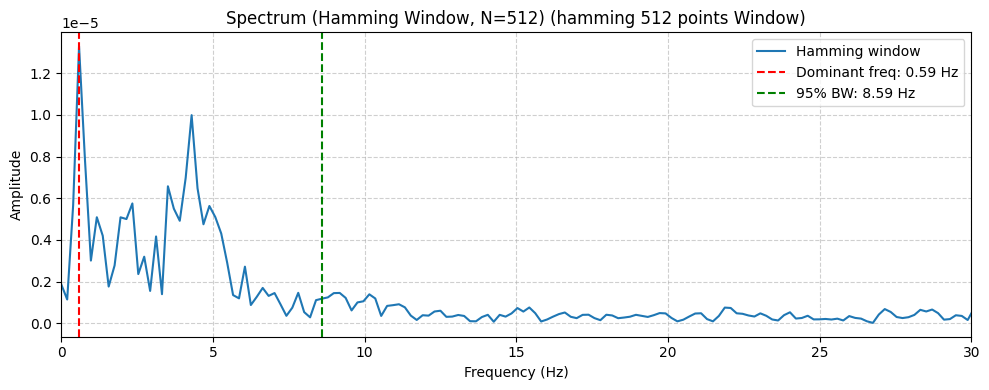

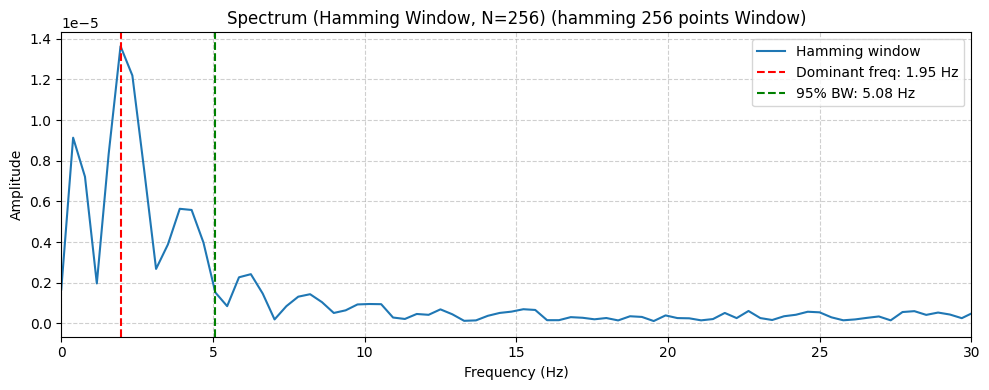

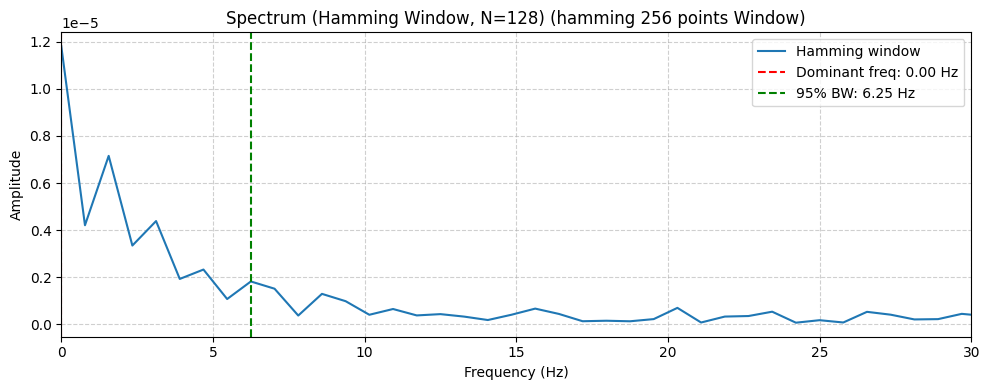

Hamming (full): dominant=0.47 Hz, 95% BW=5.23 Hz
Hamming (512): dominant=0.59 Hz, 95% BW=8.59 Hz
Hamming (256): dominant=1.95 Hz, 95% BW=5.08 Hz
Hamming (128): dominant=0.00 Hz, 95% BW=6.25 Hz


In [3]:

# 1. Hamming 窗，全长（如 3000 点，fs=100 → 30秒）
df1, bw1, _, _ = plot_spectrum(eeg, fs, window_type='hamming', nperseg=None, title_suffix="(hamming Full Length)")

# 3. Hamming 窗，短窗（例如 512 点 ≈ 5.12 秒）
df2, bw2, _, _ = plot_spectrum(eeg, fs, window_type='hamming', nperseg=512, title_suffix="(hamming 512 points Window)")

# 3. Hamming 窗，短窗（例如 256 点 ≈ 2.56 秒）
df3, bw3, _, _ = plot_spectrum(eeg, fs, window_type='hamming', nperseg=256, title_suffix="(hamming 256 points Window)")

# 3. Hamming 窗，短窗（例如 128 点 ≈ 1.28 秒）
df4, bw4, _, _ = plot_spectrum(eeg, fs, window_type='hamming', nperseg=128, title_suffix="(hamming 256 points Window)")


# 打印结果用于报告
print(f"Hamming (full): dominant={df1:.2f} Hz, 95% BW={bw1:.2f} Hz")
print(f"Hamming (512): dominant={df2:.2f} Hz, 95% BW={bw2:.2f} Hz")
print(f"Hamming (256): dominant={df3:.2f} Hz, 95% BW={bw3:.2f} Hz")
print(f"Hamming (128): dominant={df4:.2f} Hz, 95% BW={bw4:.2f} Hz")


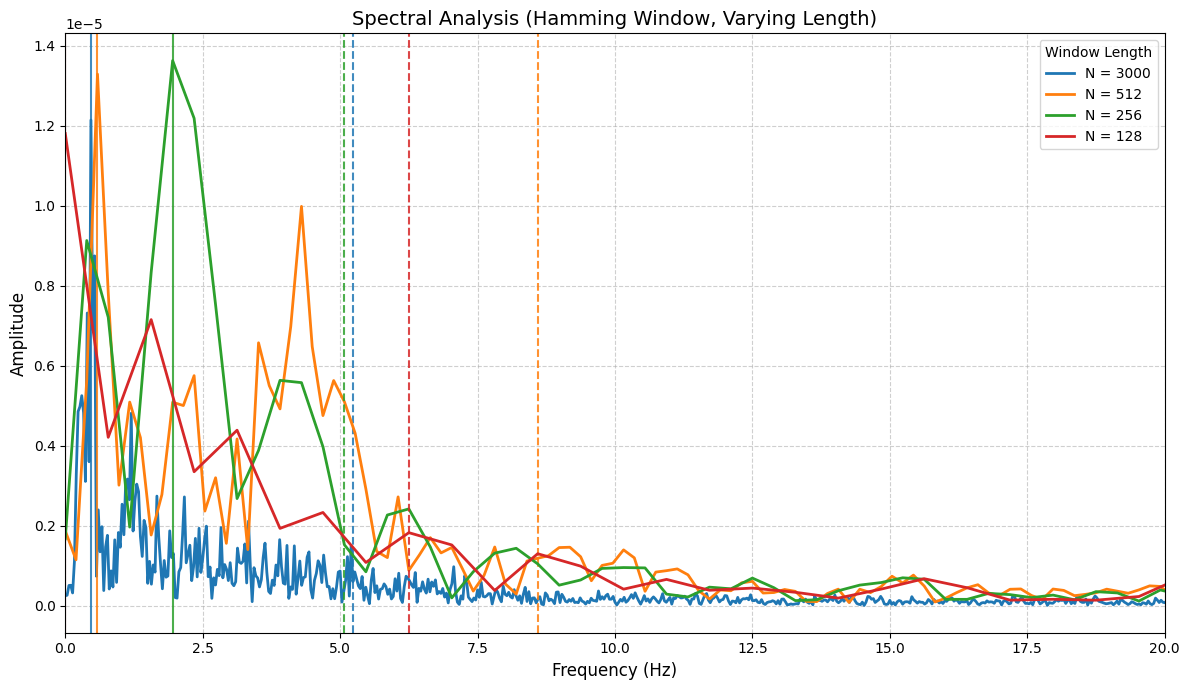

N (samples) | Dominant Freq (Hz) |    95% BW (Hz)
--------------------------------------------------
      3000 |               0.47 |           5.23
       512 |               0.59 |           8.59
       256 |               1.95 |           5.08
       128 |               0.00 |           6.25


In [4]:

# 分析 Hamming 窗下不同长度的影响
plot_fixed_window_vary_length(
    eeg,
    fs,
    window_type='hamming',
    window_lengths=[len(eeg), 512, 256, 128],
    xlim=20.0
)

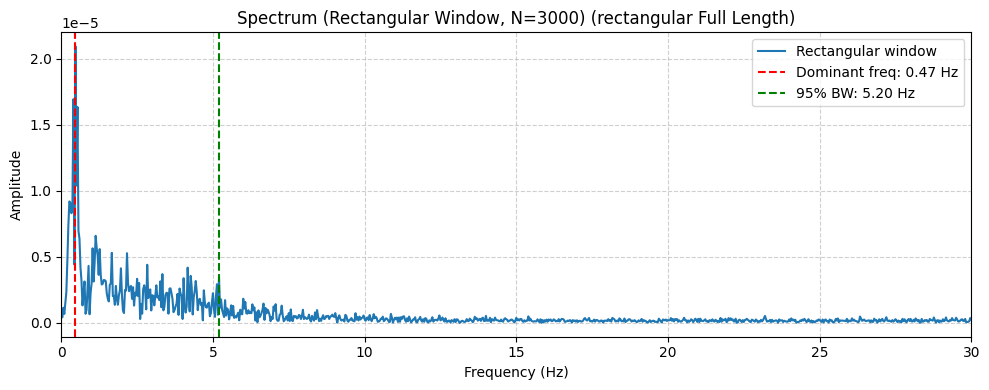

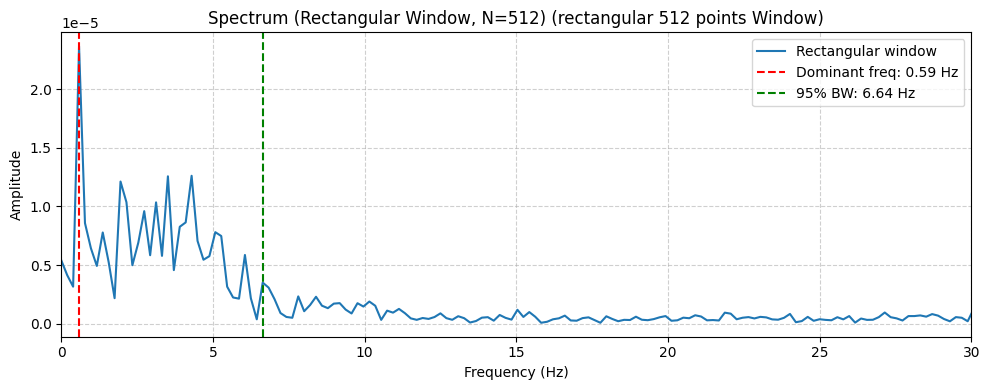

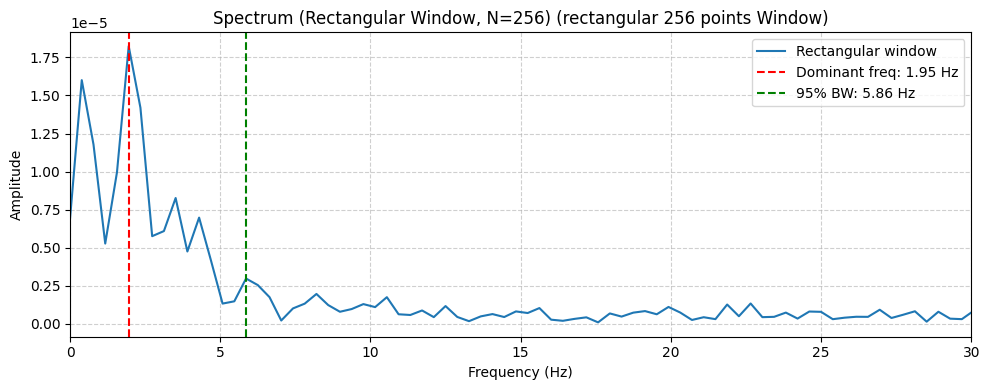

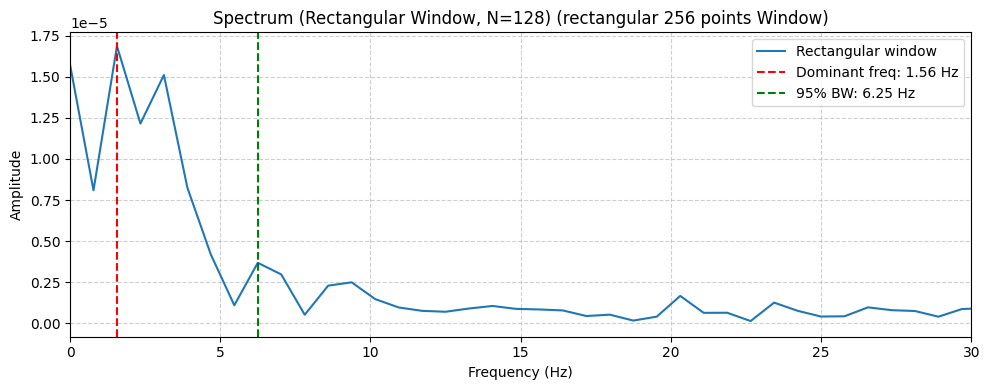

Hamming (full): dominant=0.47 Hz, 95% BW=5.20 Hz
Hamming (512): dominant=0.59 Hz, 95% BW=6.64 Hz
Hamming (256): dominant=1.95 Hz, 95% BW=5.86 Hz
Hamming (128): dominant=1.56 Hz, 95% BW=6.25 Hz


In [5]:

# 1. Hamming 窗，全长（如 3000 点，fs=100 → 30秒）
df1, bw1, _, _ = plot_spectrum(eeg, fs, window_type='rectangular', nperseg=None, title_suffix="(rectangular Full Length)")

# 3. Hamming 窗，短窗（例如 512 点 ≈ 5.12 秒）
df2, bw2, _, _ = plot_spectrum(eeg, fs, window_type='rectangular', nperseg=512, title_suffix="(rectangular 512 points Window)")

# 3. Hamming 窗，短窗（例如 256 点 ≈ 2.56 秒）
df3, bw3, _, _ = plot_spectrum(eeg, fs, window_type='rectangular', nperseg=256, title_suffix="(rectangular 256 points Window)")

# 3. Hamming 窗，短窗（例如 128 点 ≈ 1.28 秒）
df4, bw4, _, _ = plot_spectrum(eeg, fs, window_type='rectangular', nperseg=128, title_suffix="(rectangular 256 points Window)")


# 打印结果用于报告
print(f"Hamming (full): dominant={df1:.2f} Hz, 95% BW={bw1:.2f} Hz")
print(f"Hamming (512): dominant={df2:.2f} Hz, 95% BW={bw2:.2f} Hz")
print(f"Hamming (256): dominant={df3:.2f} Hz, 95% BW={bw3:.2f} Hz")
print(f"Hamming (128): dominant={df4:.2f} Hz, 95% BW={bw4:.2f} Hz")

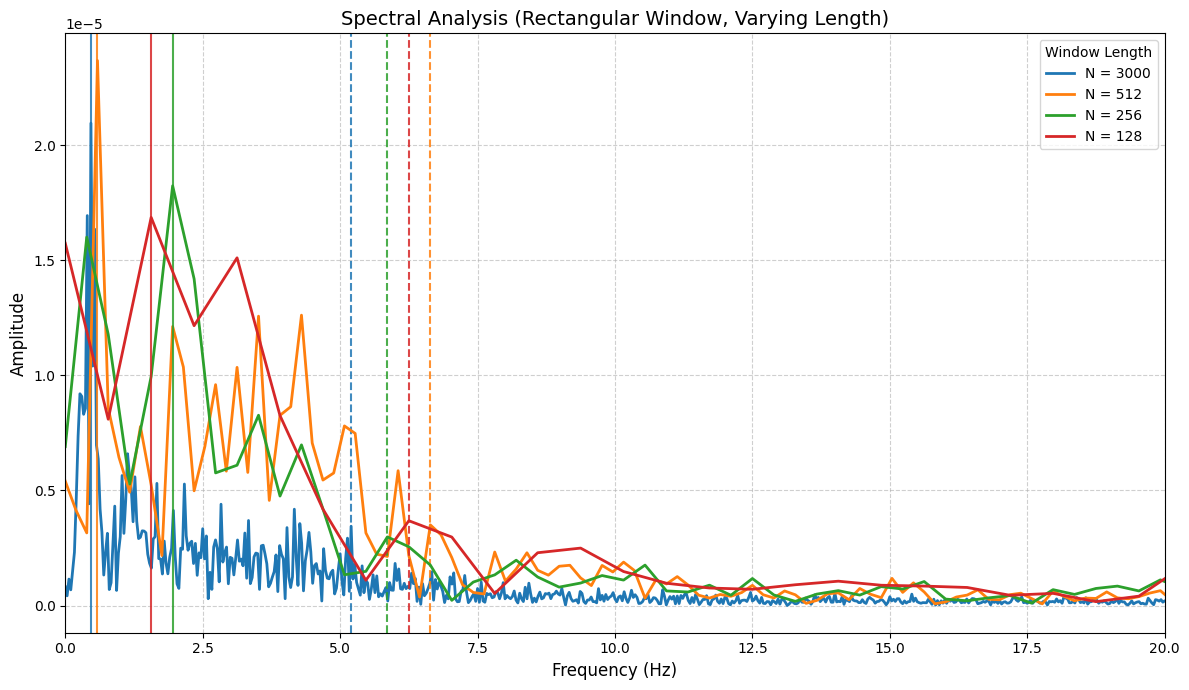

N (samples) | Dominant Freq (Hz) |    95% BW (Hz)
--------------------------------------------------
      3000 |               0.47 |           5.20
       512 |               0.59 |           6.64
       256 |               1.95 |           5.86
       128 |               1.56 |           6.25


In [6]:

# 分析 Hamming 窗下不同长度的影响
plot_fixed_window_vary_length(
    eeg,
    fs,
    window_type='rectangular',
    window_lengths=[len(eeg), 512, 256, 128],
    xlim=20.0
)

In [7]:
eeg.shape

(3000,)

### III. Adding Interference

To simulate realistic artifacts commonly observed in clinical EEG recordings, two types of interference were intentionally added to the clean sleep EEG signal:

1. **Fixed-frequency sinusoidal interference** at 50 Hz and 100 Hz, representing powerline noise and its second harmonic.  
   - The amplitude of each sinusoid is defined as a **relative percentage of the original EEG’s standard deviation** (e.g., 50% for 10 Hz, 40% for 15 Hz, 30% for 20Hz and 20% for 25Hz).  
   - This ensures the interference is clearly visible in the spectrum while remaining physiologically plausible and **removable via digital filtering**.

2. **Additive White Gaussian Noise (AWGN)** to model sensor thermal noise and background electromagnetic interference.  
   - The noise level is controlled by a target **Signal-to-Noise Ratio (SNR) of 5 dB**, computed as:  
     $$
     \text{SNR}_{\text{dB}} = 10 \log_{10} \left( \frac{\text{Signal Power}}{\text{Noise Power}} \right)
     $$
   - Signal power is estimated as the mean squared value of the clean EEG, making the noise intensity **adaptive and relative** to the signal itself.

The resulting noisy signal exhibits:
- A sharp spectral peak at 50 Hz (and 100 Hz),
- Elevated broadband noise floor due to AWGN.

These characteristics are clearly visible in the frequency spectrum (see Figure X), confirming successful interference injection. Both noise types are deliberately chosen to be **practically removable**: narrowband components via notch/band-stop filters, and broadband noise via low-pass filtering—aligning with the project’s filter design objective.

In [8]:

# ----------------------------
# Example Usage (for your report)
# ----------------------------

# Add interference
noisy_eeg, noise = add_interference_to_eeg(
    eeg,
    fs,
    noise_types=['fixed_freq', 'white'],
    fixed_freqs=[10, 15, 20, 25],
    relative_amplitudes=[0.5,0.4,0.3, 0.2],   # 20% and 10% of EEG std
    amplitude_ref='std',              # 或 'peak'
    snr_db=5.0
)

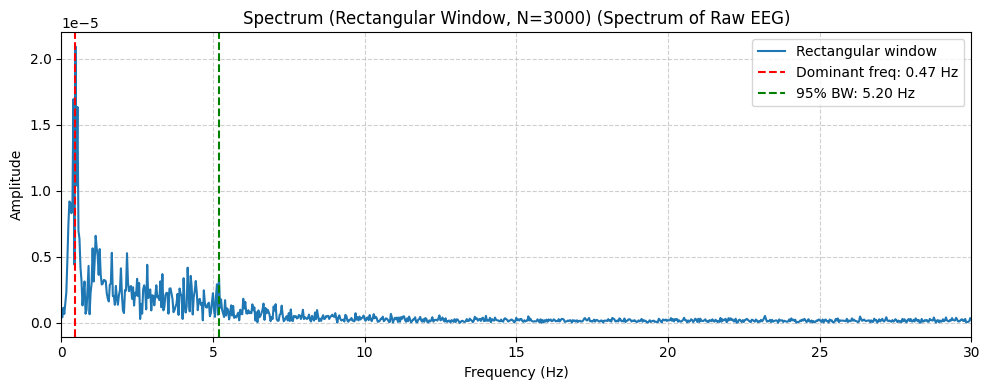

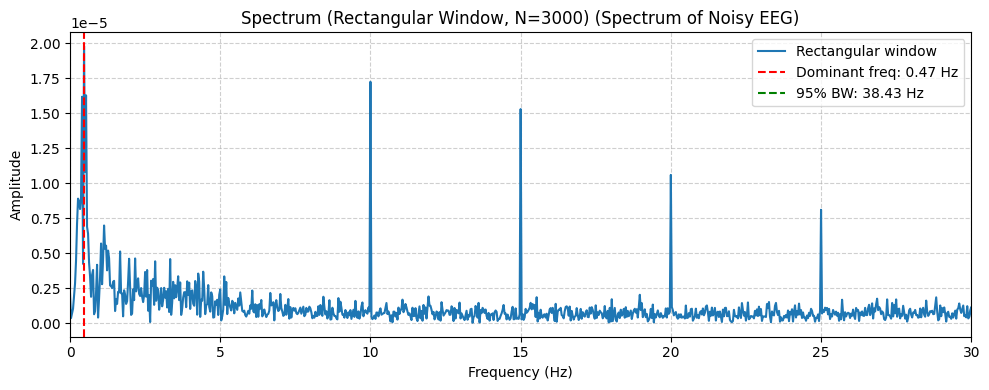

In [9]:
df_raw, bw_raw, _, _ = plot_spectrum(eeg, fs, window_type='rectangular', nperseg=None, title_suffix="(Spectrum of Raw EEG)")
df_with_noise, bw_with_noise, _, _ = plot_spectrum(noisy_eeg, fs, window_type='rectangular', nperseg=None, title_suffix="(Spectrum of Noisy EEG)")

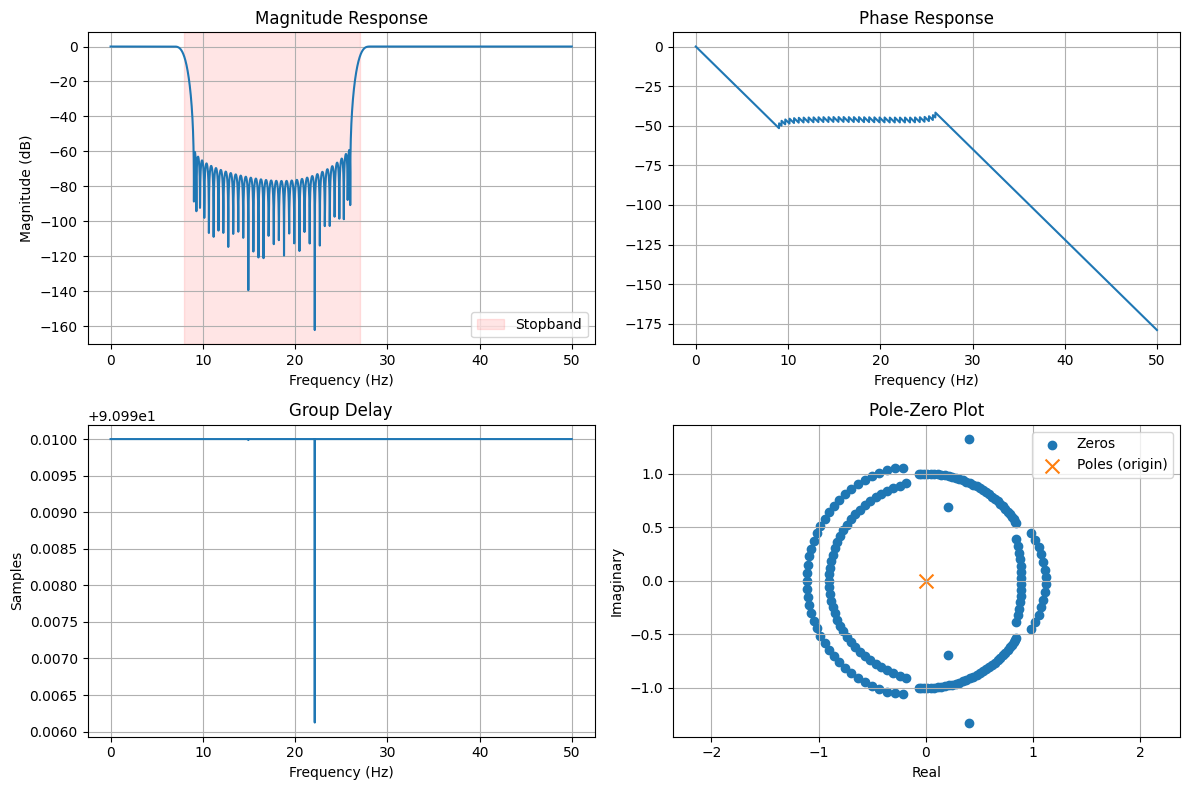

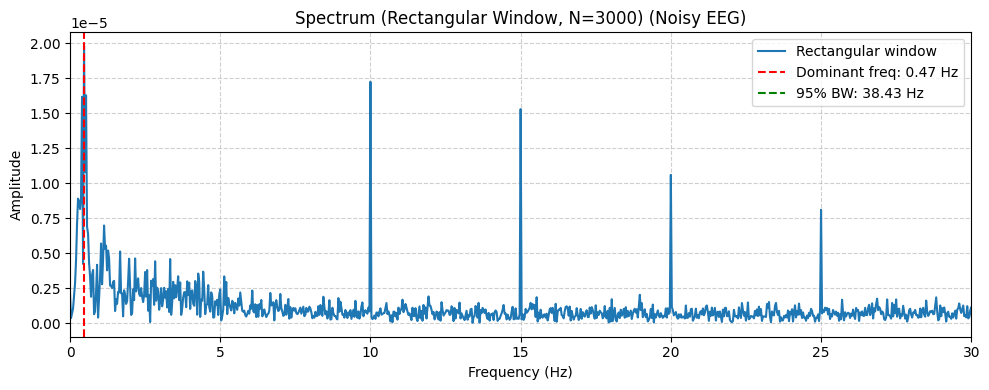

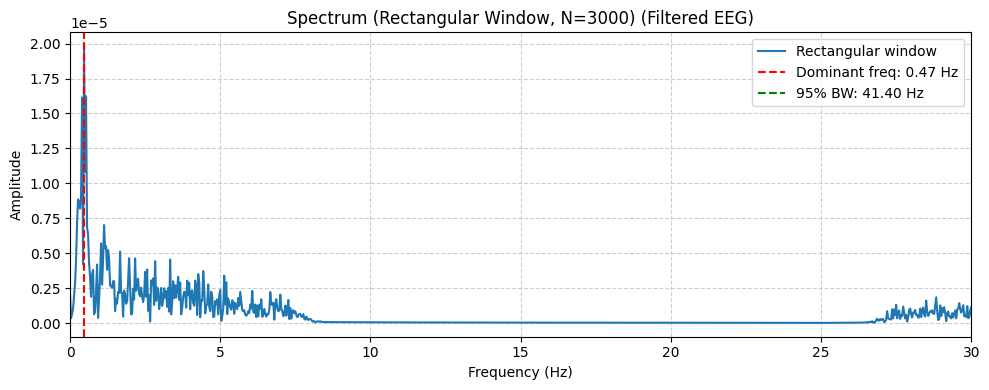

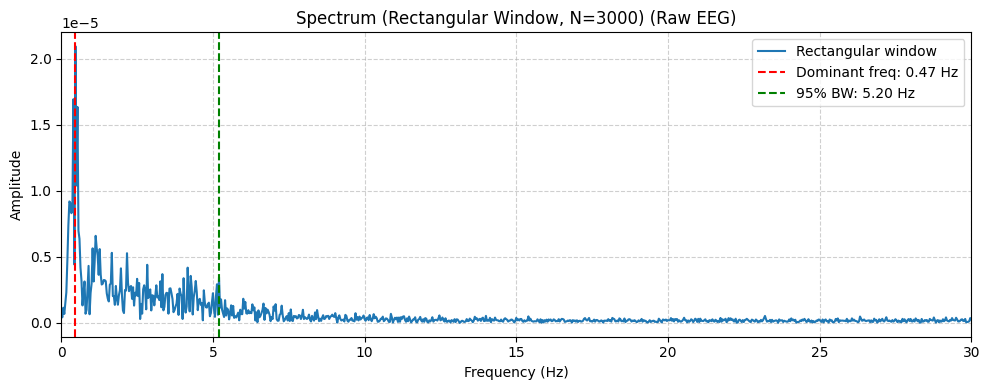

In [11]:
filtered_eeg, b = design_and_apply_fir_bandstop(
    noisy_eeg,
    fs,
    stopband=(8, 27),           # 覆盖 10–25 Hz 干扰
    stopband_attenuation=60,    # 强抑制
    plot_response=True
)


df_raw, bw_raw, _, _ = plot_spectrum(noisy_eeg, fs, window_type='rectangular', nperseg=None, title_suffix="(Noisy EEG)")
df_raw, bw_raw, _, _ = plot_spectrum(filtered_eeg, fs, window_type='rectangular', nperseg=None, title_suffix="(Filtered EEG)")
df_raw, bw_raw, _, _ = plot_spectrum(eeg, fs, window_type='rectangular', nperseg=None, title_suffix="(Raw EEG)")
